In [1]:
pip install -U scikit-fuzzy

In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate universe variables
# * Quality and service on subjective ranges [0, 10]
# * Tip has a range of [0, 25] in units of percentage points
x_temperature = np.arange(0, 101, 1)
x_cloudCover = np.arange(0, 11, 1)
x_speed = np.arange(0, 101, 1)

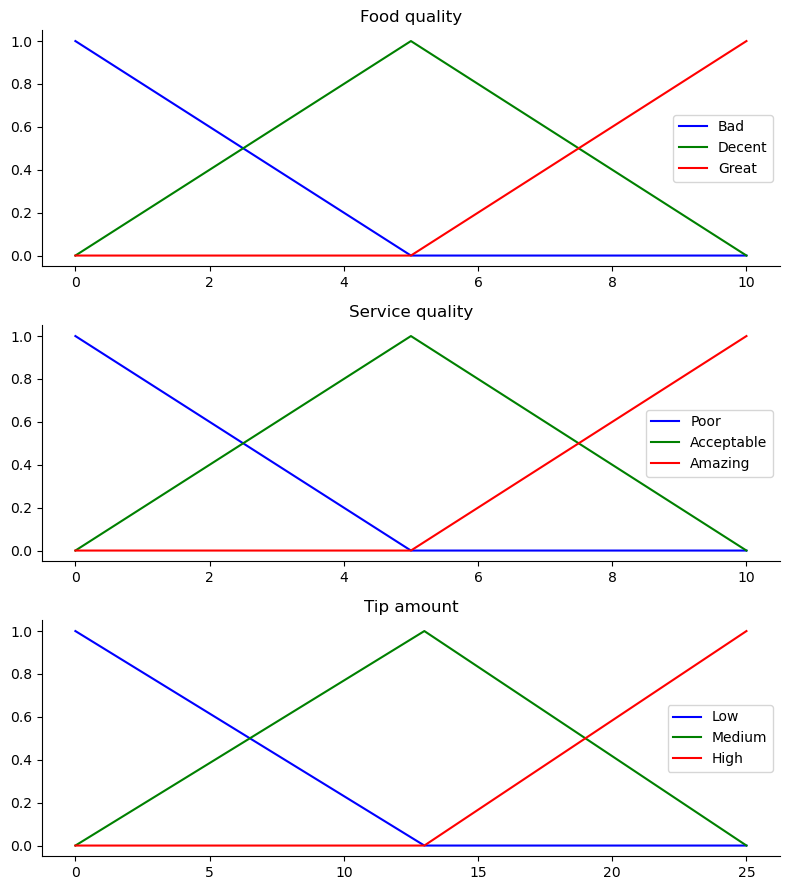

In [11]:
# Generate fuzzy membership functions
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])  # Triangular membership function
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    plt.tight_layout()

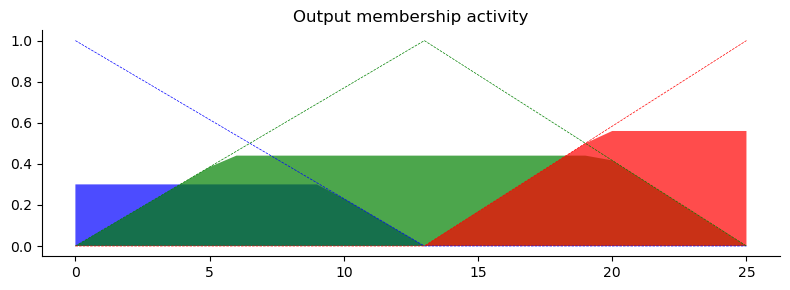

In [15]:
'''Now, to make these triangles useful, we deﬁne the fuzzy relationship between input and output variables. For the
purposes of our example, consider three simple rules:
1. If the food is bad OR the service is poor, then the tip will be low
2. If the service is acceptable, then the tip will be medium
3. If the food is great OR the service is amazing, then the tip will be high.
Rule application
What would the tip be in the following circumstance:
• Food quality was 6.5
• Service was 9.8 '''
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 3.5) # For finding out fuzziness of 3.5 as low quality (maybe 70%)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 3.5) # For finding out fuzziness of 3.5 as med quality (maybe 29%)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 3.5) # For finding out fuzziness of 3.5 as high quality (maybe 1%)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 7.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 7.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 7.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo) #Fuzzy max rule (OR)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
#fmin - Fuzzy min rule (AND)
tip_activation_lo = np.fmin(active_rule1, tip_lo) # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi) # Fuzzy max (OR)
tip_activation_hi = np.fmin(active_rule3, tip_hi) # Fuzzy min (AND)

tip0 = np.zeros_like(x_tip)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

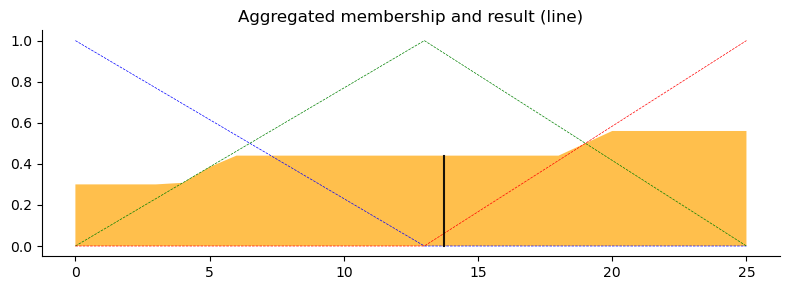

In [14]:
# Deffuzzification, Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip) # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    plt.tight_layout()